# Quick Start (single-variate)

In this section, we are going to generate some synthetic single variate time series data, inject some anomalies into test data. And then use some Machine learning techniques to detect these anomalies.

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import random
import warnings

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")
%matplotlib inline
plt.rcParams["figure.figsize"] = [9, 2]
plt.rcParams["figure.dpi"] = 200
plt.rcParams["agg.path.chunksize"] = 100000
pd.set_option("plotting.backend", "matplotlib")
random.seed(42)
np.random.seed(42)

<IPython.core.display.Javascript object>

## 1. Data Generation 

Numalogic provides a synthetic time series data generator, that can be used to experiment and evaluate different ML alogorithms. Here we are generaing a single timeseries (num_series) with 9000 data points.

For more details on synthetic data generation, please refer to [data generator](../docs/data-generator.md)

In [3]:
TOTAL_SIZE = 9000
VALIDATION_SIZE = 1000
TEST_SIZE = 1000

<IPython.core.display.Javascript object>

In [4]:
from numalogic.synthetic import SyntheticTSGenerator

ts_generator = SyntheticTSGenerator(
    seq_len=TOTAL_SIZE,
    num_series=1,
    freq="T",
    primary_period=600,
    secondary_period=3000,
    seasonal_ts_prob=1.0,
    baseline_range=(200.0, 350.0),
    slope_range=(-0.001, 0.01),
    amplitude_range=(10, 75),
    cosine_ratio_range=(0.5, 0.9),
    noise_range=(5, 15),
)

# shape: (9000, 1) with column names [s1]
ts_df = ts_generator.gen_tseries()

<IPython.core.display.Javascript object>

<AxesSubplot:title={'center':'Time series data'}>

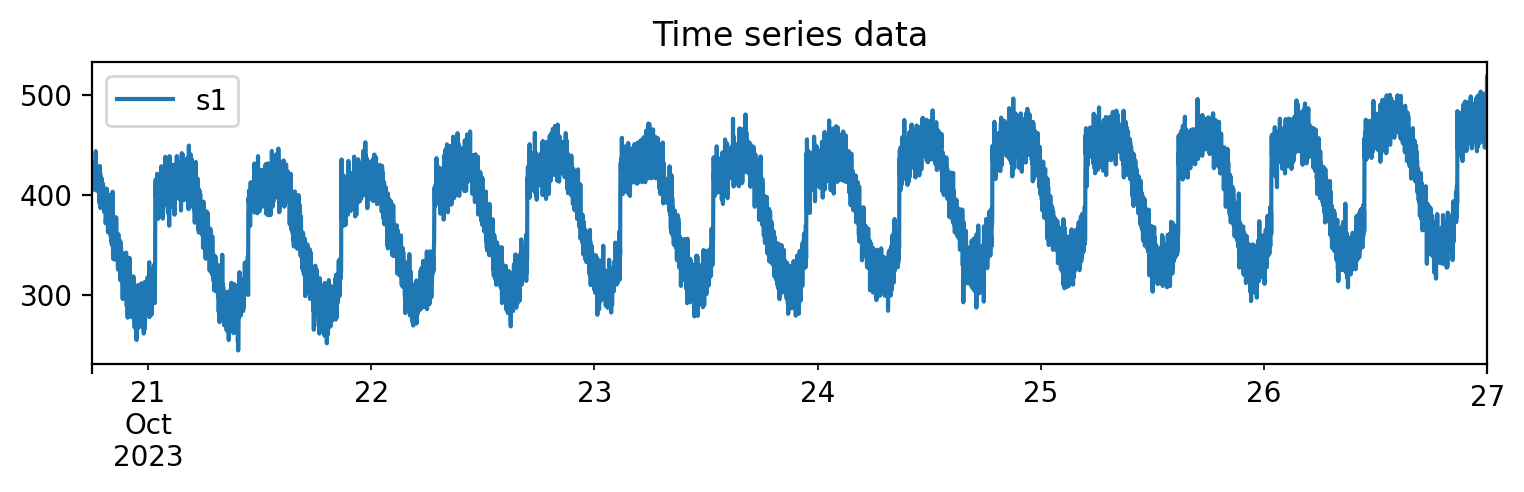

<IPython.core.display.Javascript object>

In [5]:
ts_df.plot(title="Time series data")

Now, we split the generated data into train and test dataframes, with test set size 1000, validation set size as 1000, leaving 7000 datapoints for training.

In [6]:
train_df, test_df = ts_generator.train_test_split(ts_df, test_size=TEST_SIZE)
train_df, val_df = ts_generator.train_test_split(train_df, test_size=VALIDATION_SIZE)
print(
    f"train shape: {train_df.shape}\nval shape: {val_df.shape}\ntest shape: {test_df.shape}"
)

train shape: (7000, 1)
val shape: (1000, 1)
test shape: (1000, 1)


<IPython.core.display.Javascript object>

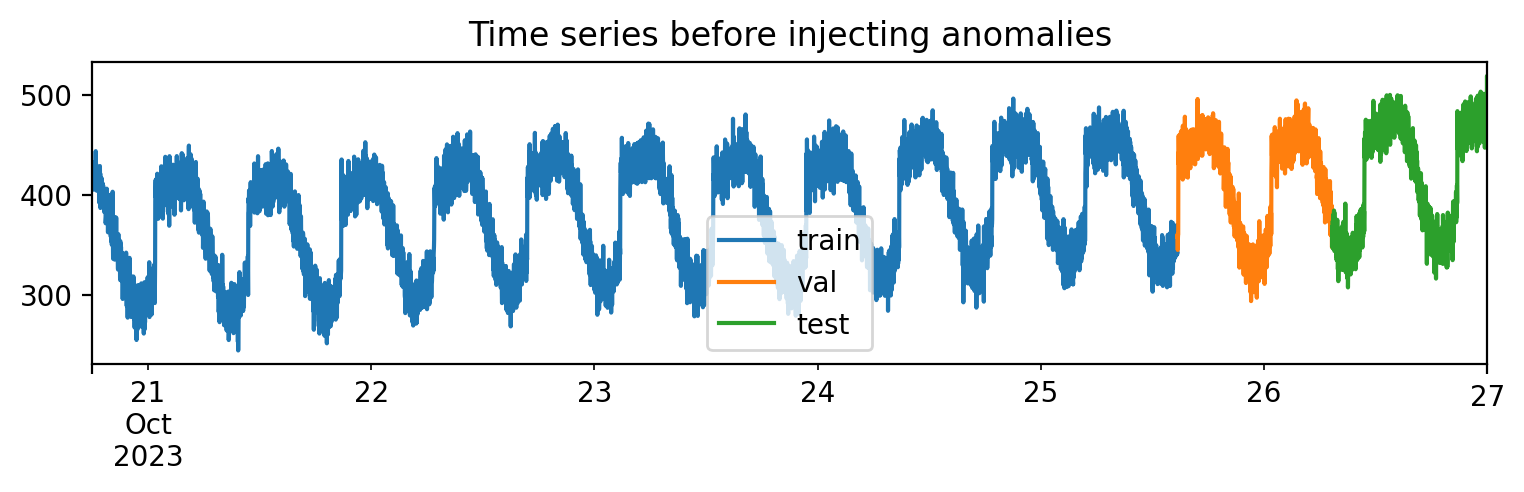

<IPython.core.display.Javascript object>

In [7]:
ax = train_df["s1"].plot(label="train")
val_df["s1"].plot(ax=ax, label="val")
test_df["s1"].plot(ax=ax, label="test", title="Time series before injecting anomalies")
plt.legend()

## 2. Inject anomalies:

Now, we inject anomalies into the test set using the `AnomalyGenerator`. Here we are adding `contextual` anomalies, you could also try `causal` or `collective` anomalies.

In [8]:
from numalogic.synthetic import AnomalyGenerator

anomaly_generator = AnomalyGenerator(
    train_df, anomaly_type="contextual", anomaly_ratio=0.2
)
outliers_test_df = anomaly_generator.inject_anomalies(test_df, cols=["s1"], impact=1)
outliers_test_df.drop(columns="is_anomaly", inplace=True)

<IPython.core.display.Javascript object>

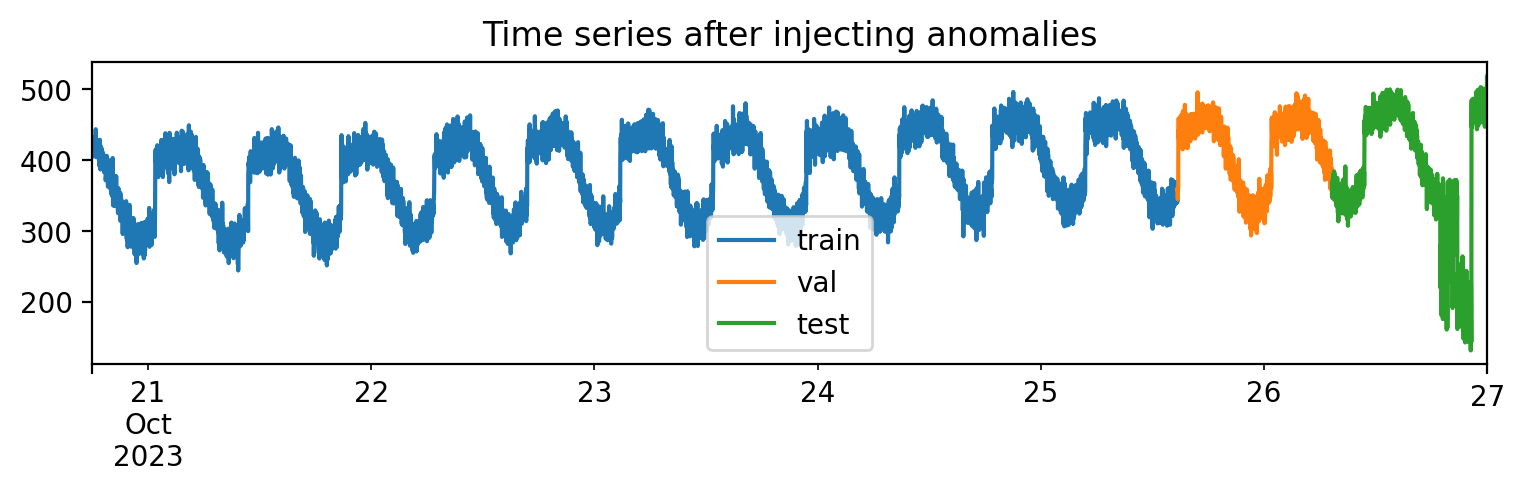

<IPython.core.display.Javascript object>

In [9]:
ax = train_df["s1"].plot(label="train")
val_df["s1"].plot(ax=ax, label="val")
outliers_test_df["s1"].plot(
    ax=ax, label="test", title="Time series after injecting anomalies"
)
plt.legend()

## 3. Pre-Processing:

Pre-processing is an optional step, where we can clean, scale or transform the data. We can transform the features by scaling each feature to a given range, while keeping the shape of the distribution same. 

Here we are using `TanhScaler` from numalogic, you could also try other scikit-learn scalers like `StandarScaler` or `RobustScaler`.

In [10]:
from numalogic.transforms import TanhScaler

scaler = TanhScaler()
X_train = scaler.fit_transform(train_df.to_numpy())
X_val = scaler.transform(val_df.to_numpy())
X_test = scaler.transform(outliers_test_df.to_numpy())

<IPython.core.display.Javascript object>

## 4. Training:

In the training step, we define the model and train it on the training data set.
Let's use simple 1D convolutional autoencoder for this pr

In [11]:
from torch.utils.data import DataLoader
from numalogic.models.autoencoder import AutoencoderTrainer
from numalogic.models.autoencoder.variants import Conv1dAE
from numalogic.tools.data import StreamingDataset

SEQ_LEN = 24  # length of the sequence
MAX_EPOCHS = 30  # number of epochs to run
BATCH_SIZE = 64  # training batch size

model = Conv1dAE(seq_len=SEQ_LEN, in_channels=1, enc_channels=(8, 4))
model

Conv1dAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): ConvBlock(
        (conv): Conv1d(1, 8, kernel_size=(3,), stride=(1,), padding=(1,))
        (bnorm): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): Conv1d(8, 4, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): ReLU()
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): ConvTransposeBlock(
        (convtranspose): ConvTranspose1d(4, 8, kernel_size=(3,), stride=(1,), padding=(1,))
        (bnorm): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): Upsample(scale_factor=2.0, mode='linear')
      (2): ConvTranspose1d(8, 1, kernel_size=(3,), stride=(1,), padding=(1,))
    )
  )
)

<IPython.core.display.Javascript object>

In [12]:
trainer = AutoencoderTrainer(max_epochs=MAX_EPOCHS, enable_progress_bar=True)
trainer.fit(
    model,
    train_dataloaders=DataLoader(
        StreamingDataset(X_train, seq_len=SEQ_LEN), batch_size=BATCH_SIZE
    ),
    val_dataloaders=DataLoader(
        StreamingDataset(X_val, seq_len=SEQ_LEN), batch_size=BATCH_SIZE
    ),
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=30` reached.


<IPython.core.display.Javascript object>

## 5. Threshold calculation:

After training the main model, we need to perform a threshold calculation. The autoencoder tries to encode the representation of the normal input data,
and tries to reconstuct the output. The difference between the actual input and the reconstructed output is what we call as the reconstruction error.

Some amount of recconstruction error is normal, and we need to know what amount is normal, and what can be called as an outlier.

torch.Size([7000, 1])


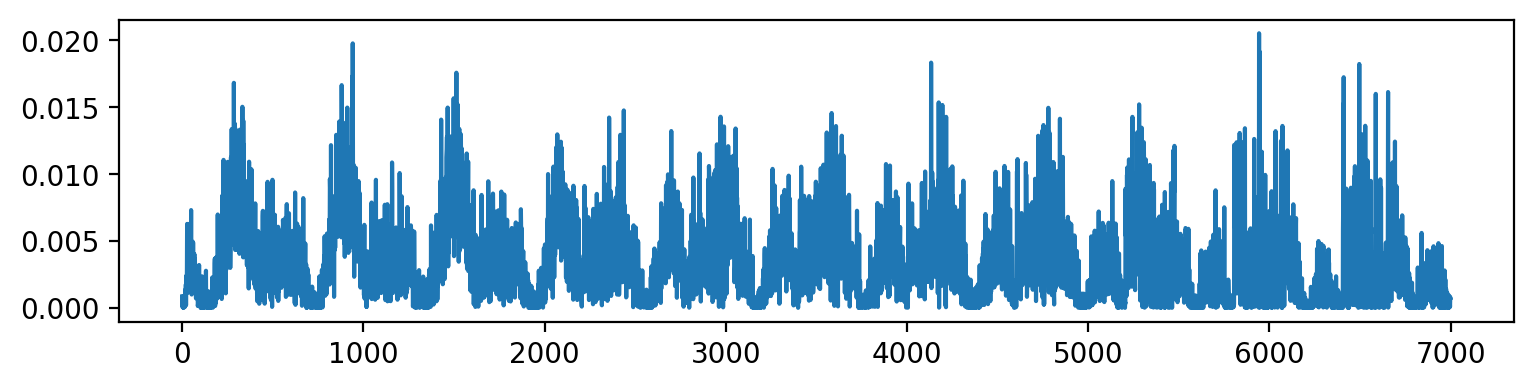

<IPython.core.display.Javascript object>

In [13]:
# Calculate training set reconstruction error
train_reconerr = trainer.predict(
    model, dataloaders=DataLoader(StreamingDataset(X_train, seq_len=SEQ_LEN))
)
print(train_reconerr.shape)
plt.plot(train_reconerr)

torch.Size([1000, 1])


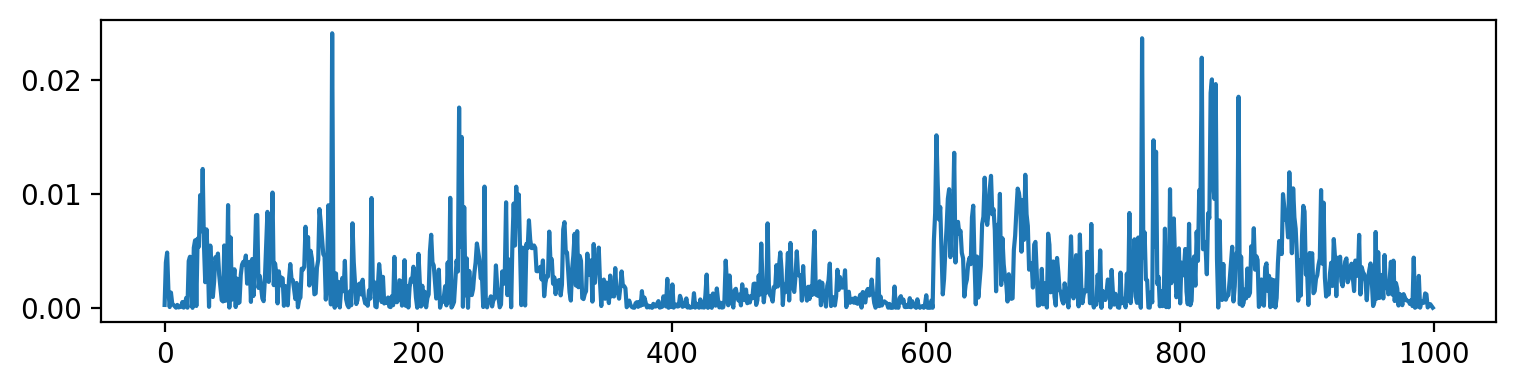

<IPython.core.display.Javascript object>

In [14]:
# Calculate validation set reconstruction error
val_reconerr = trainer.predict(
    model, dataloaders=DataLoader(StreamingDataset(X_val, seq_len=SEQ_LEN))
)
print(val_reconerr.shape)
plt.plot(val_reconerr)

Now, we say that anything more than 3 times the standard deviation from the mean is anomalous.

In [15]:
# Calculate the threshold
from numalogic.models.threshold import StdDevThreshold

threshold_clf = StdDevThreshold(std_factor=3.0)
_ = threshold_clf.fit(val_reconerr.numpy())

<IPython.core.display.Javascript object>

## 6. Inference:

Now, we use the trained model from above to predict anomalies in the test data. The predict method return the reconstruction error produced by the model. 

Score method returns the anomaly score, calculated using thresholds. If the score is less than 1, it indicates an inlier. And the score greater than 1 indicates an outlier or anomaly.

torch.Size([1000, 1])


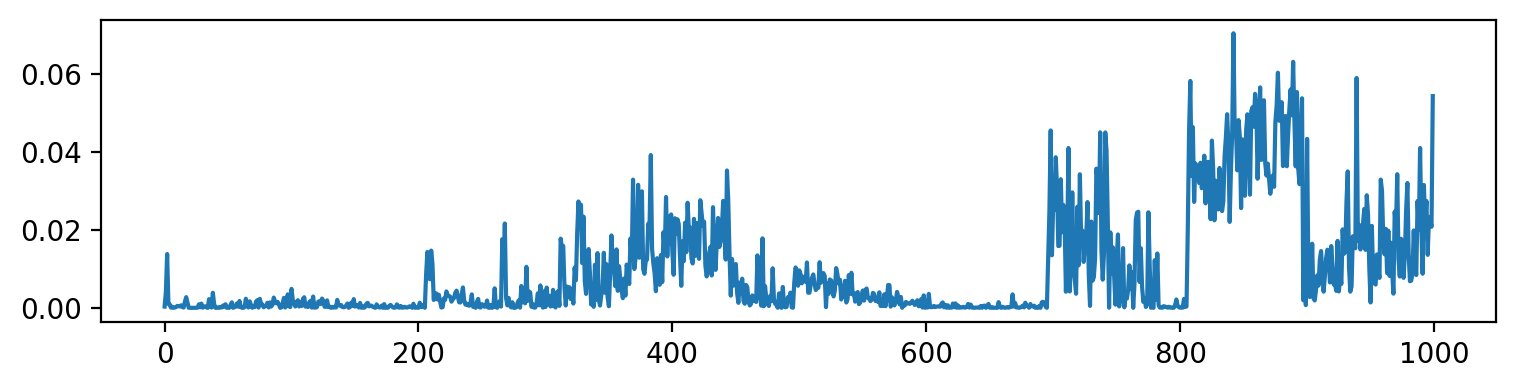

<IPython.core.display.Javascript object>

In [16]:
# Get the reconstruction error on the test set
test_recon_err = trainer.predict(
    model, dataloaders=DataLoader(StreamingDataset(X_test, seq_len=SEQ_LEN))
)
print(test_recon_err.shape)
plt.plot(test_recon_err)

In [17]:
# Get the anomaly score using the threshold estimator.
test_anomaly_score = threshold_clf.score_samples(test_recon_err.numpy())
print(test_anomaly_score.shape)

(1000, 1)


<IPython.core.display.Javascript object>

<AxesSubplot:>

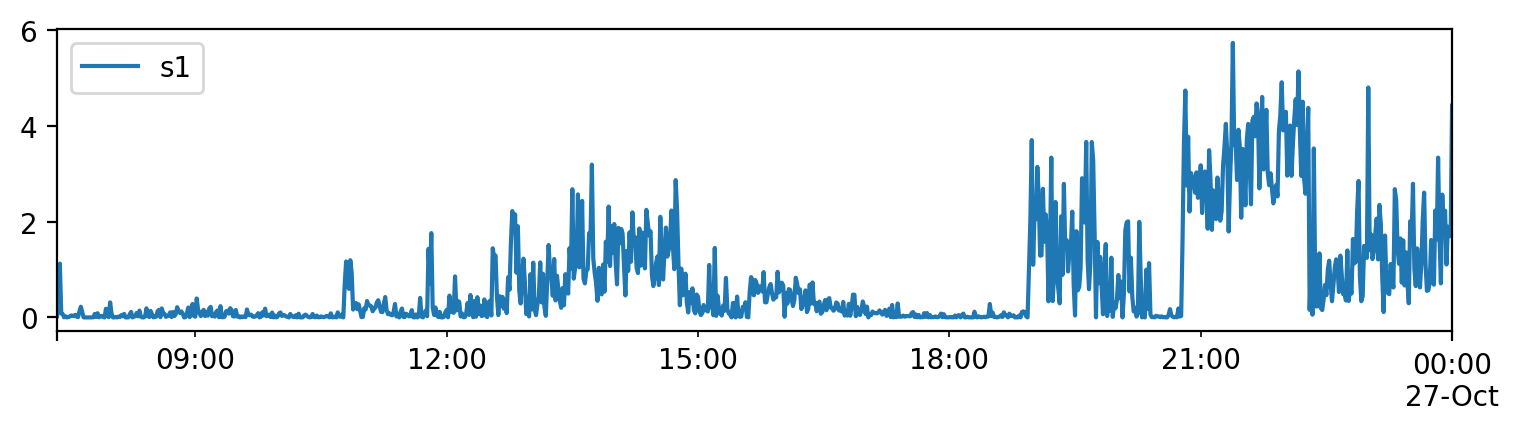

<IPython.core.display.Javascript object>

In [18]:
# Convert the score array into a dataframe
anomalies_df = pd.DataFrame(
    data=test_anomaly_score,
    columns=outliers_test_df.columns,
    index=outliers_test_df.index,
)
anomalies_df.plot()

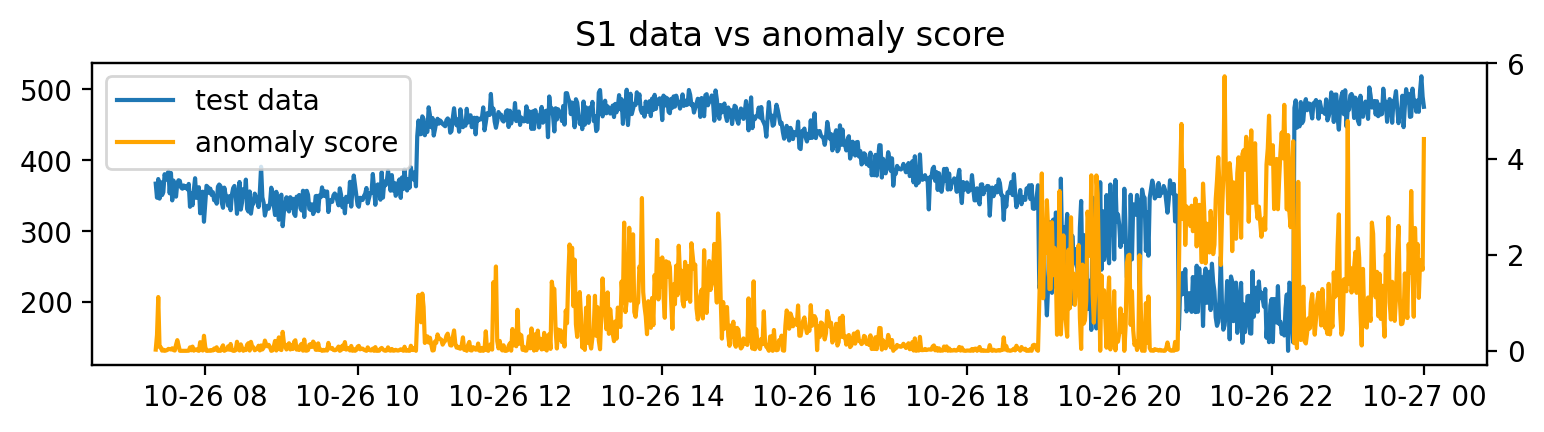

<IPython.core.display.Javascript object>

In [19]:
ax1 = plt.subplot()
(l1,) = ax1.plot(outliers_test_df["s1"])
ax2 = ax1.twinx()
(l2,) = ax2.plot(anomalies_df["s1"], color="orange")
plt.legend([l1, l2], ["test data", "anomaly score"])
plt.title("S1 data vs anomaly score")
plt.show()

## 7. Post-processing:
Post-processing step is an optional step, where we normalize the anomalies between 0-10. This can make the scores more human interpretable.


In [20]:
from numalogic.transforms import TanhNorm

# scale factor makes sure that the scores are normalized between 0 and 10
postproc_clf = TanhNorm(scale_factor=10)
test_anomaly_score_norm = postproc_clf.fit_transform(test_anomaly_score)
print(test_anomaly_score_norm.shape)

(1000, 1)


<IPython.core.display.Javascript object>

<AxesSubplot:>

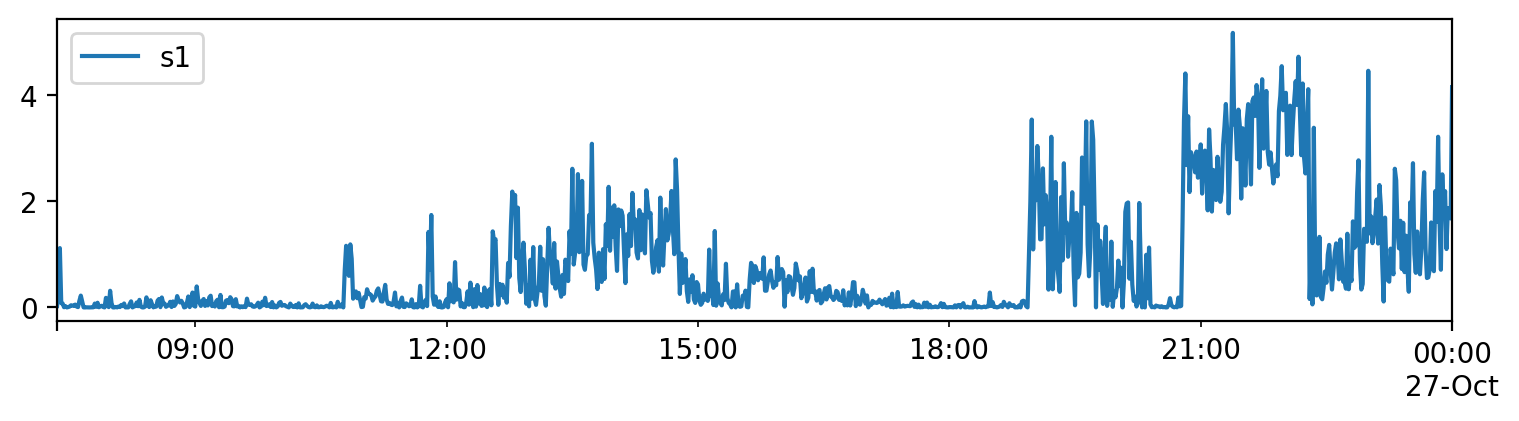

<IPython.core.display.Javascript object>

In [21]:
norm_anomalies_df = pd.DataFrame(
    data=test_anomaly_score_norm,
    columns=outliers_test_df.columns,
    index=outliers_test_df.index,
)
norm_anomalies_df.plot()

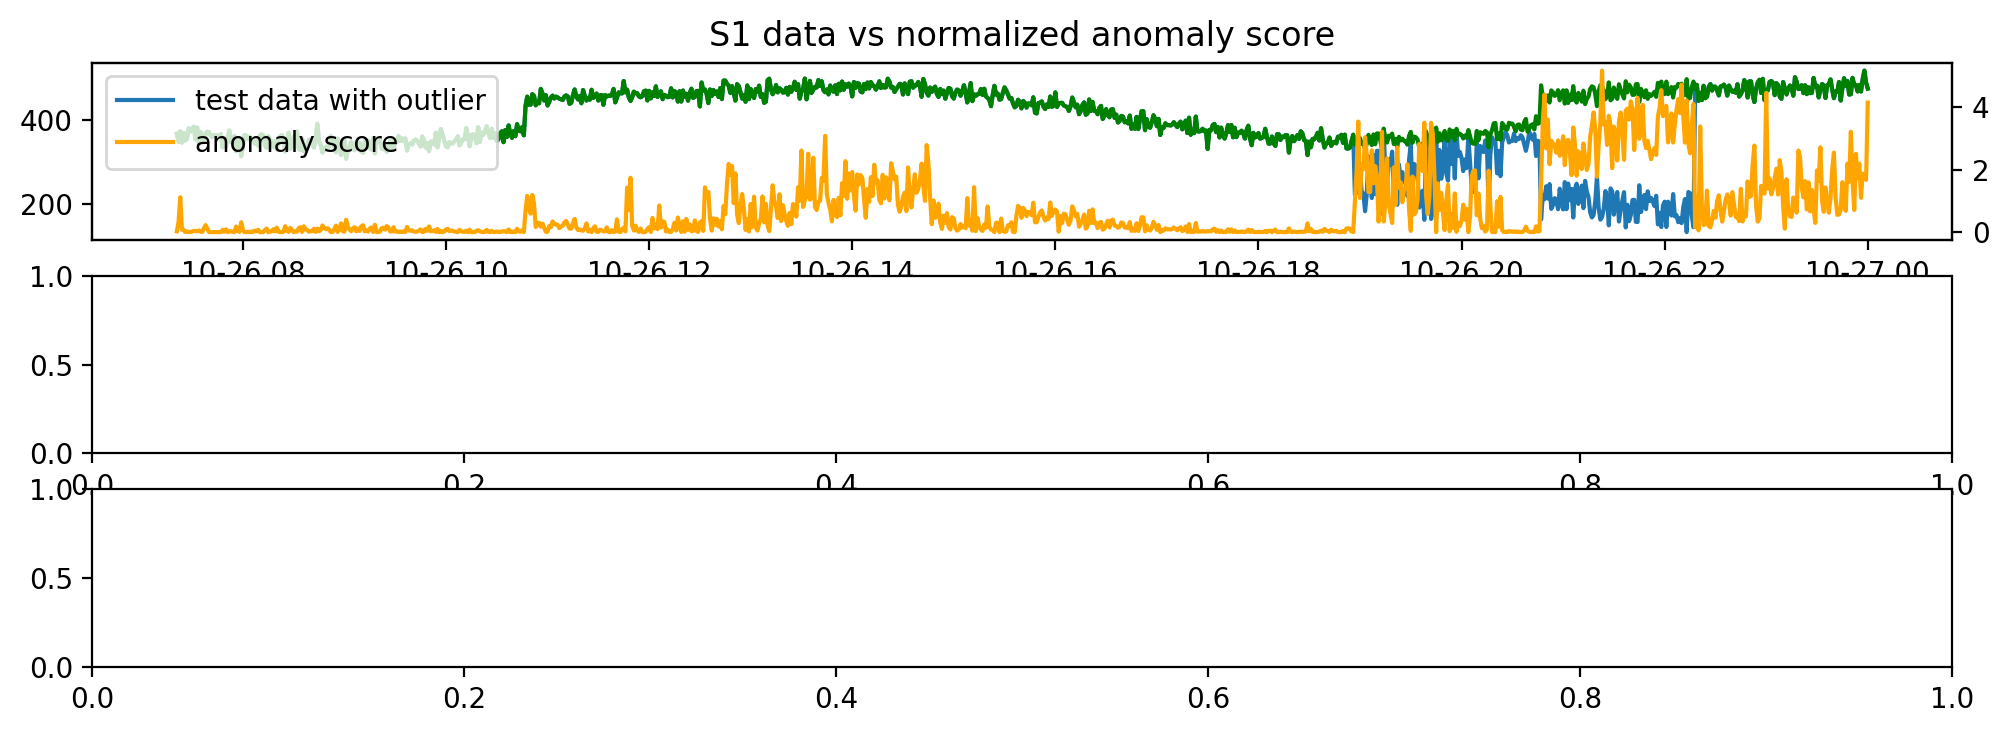

<IPython.core.display.Javascript object>

In [22]:
f, ax1 = plt.subplots(3, 1, figsize=(12, 4))
l1, = ax1[0].plot(outliers_test_df["s1"])
ax2 = ax1[0].twinx()
l2, = ax2.plot(norm_anomalies_df["s1"], color="orange")
l3 = ax1[0].plot(test_df["s1"], color="g")
plt.legend([l1, l2, l3], ["test data with outlier", "anomaly score", "test data"])
plt.title("S1 data vs normalized anomaly score")
plt.show()

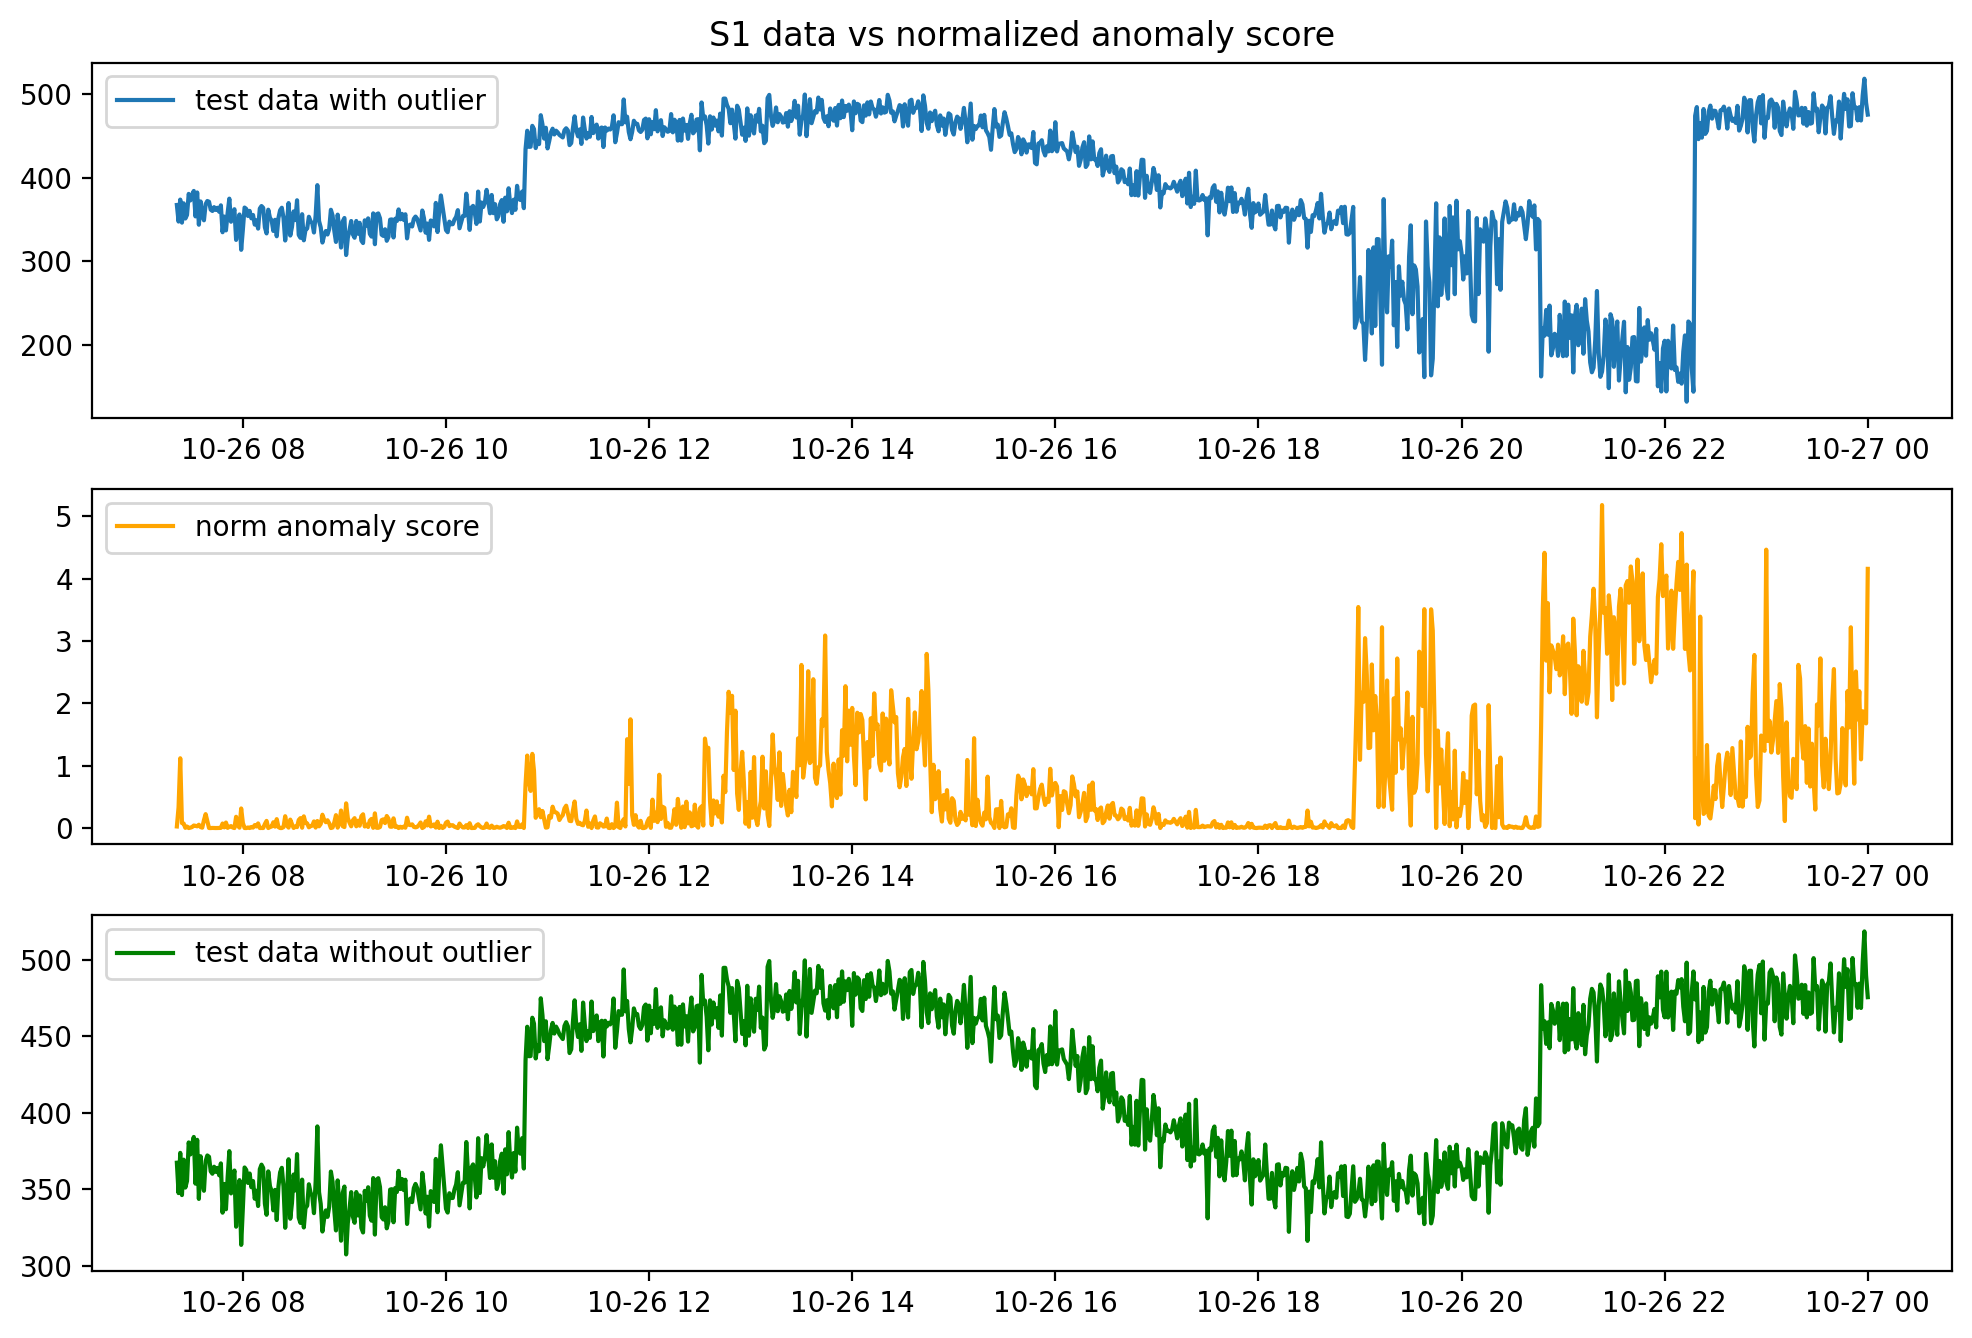

<IPython.core.display.Javascript object>

In [23]:
_, axes = plt.subplots(3, 1, figsize=(12, 8))
(l1,) = axes[0].plot(outliers_test_df["s1"], label="test data with outlier")
axes[0].legend()
axes[0].set_title("S1 data vs normalized anomaly score")
(l2,) = axes[1].plot(
    norm_anomalies_df["s1"], color="orange", label="norm anomaly score"
)
axes[1].legend()
l3 = axes[2].plot(test_df["s1"], color="g", label="test data without outlier")
axes[2].legend()